<a href="https://colab.research.google.com/github/marypthomas/ai-bootcamp-osu/blob/main/Session_9/AIBootCamp_NeuralNetworksWithImages_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Workflows for Images - A Review**

**Author**:
- Prof. Eric Fosler-Lussier, The Ohio State University

## **Multi-layer Perceptrons vs. Convolutional Neural Networks**

In this notebook, we will explore how different convolutional neural network structures result in differences in performance on the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)  dataset.  This dataset consists of 60,000 28x28 grayscale training images of clothing items of one of ten types (shirt, dress,...), and has a test set of 10,000 images.  

The code below provides some examples of how to train a deep neural network for the Fashion-MNIST database.  You can use this as a training/test harness for developing your own MLP/ConvNet.

## **Preamble**

In [ ]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support


# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms



The following library call downloads the training set and puts it into data/FashionMNIST, and prepares the dataset to be passed into a pytorch as a tensor.

## **The Data**

In [ ]:
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

test_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = False,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



## **A Multi-layer Perceptron**
Here I'm defining a network that is a 2-layer multi-layer perceptron (MLP).  

In [ ]:
# Build the neural network, expand on top of nn.Module
class MLP(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.fc1 = nn.Linear(in_features=28*28,out_features=200)
    self.fc2 = nn.Linear(in_features=200,out_features=10)


  # define forward function
  def forward(self, t):
    # fc 1
    t=t.reshape(-1,28*28)
    t=self.fc1(t)
    t=F.relu(t)

    # fc 2
    t=self.fc2(t)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t

## **A Convolutional Neural Network** 
Here's a definition of a Convolutional Neural Network (CNN) with 5x5 filters, and max pooling with a stride of two.

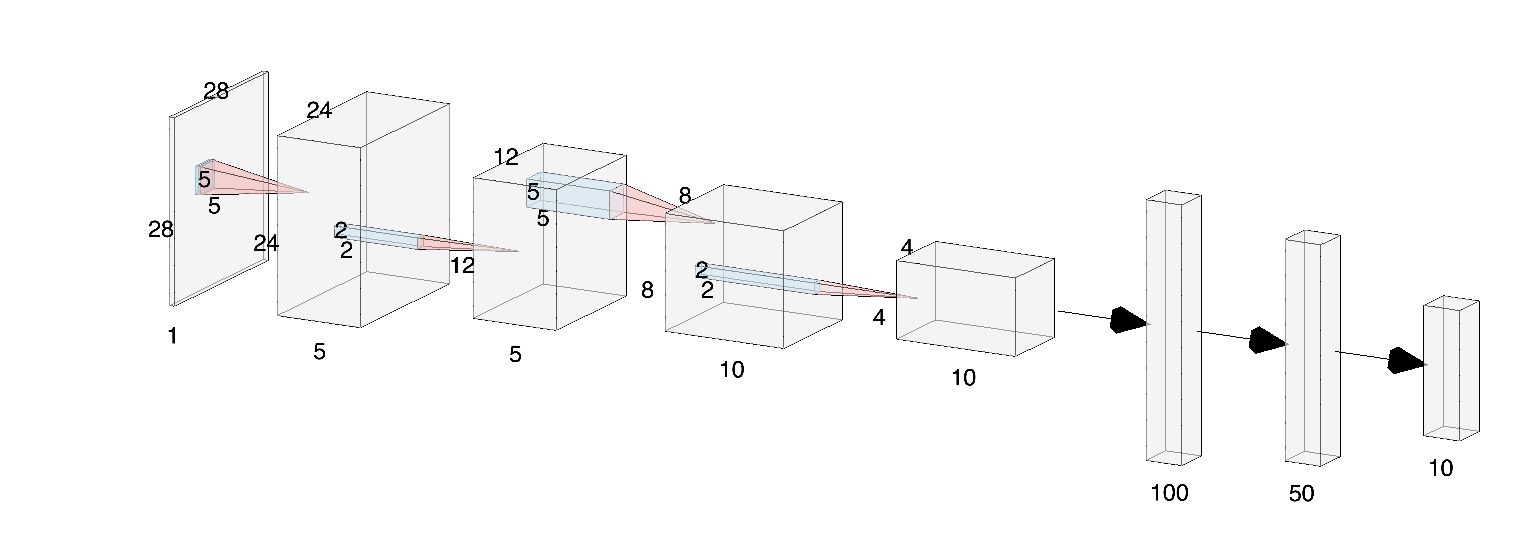

### **The Actual Construction**


In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    # first layer - take 1 channel in (gray scale), output 5 channels, convolve with 5x5 filter
    #   then pool by taking a 2x2 maximum pool
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=(5,5), stride=1, padding=0)
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), padding=0)

    # second layer - 5 channels in, 10 channels out, 5x5 filter
    #   then pool again by taking 2x2 maxpool
    self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(5,5), stride=1, padding=0)
    self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), padding=0)
    
    # Third layer - project to linear layer
    self.fc1 = nn.Linear(in_features=4*4*10,out_features=100)

    # fourth layer
    self.fc2 = nn.Linear(in_features=100,out_features=50)

    # fifth layer
    self.fc3 = nn.Linear(in_features=50,out_features=10)


  # define forward function
  def forward(self, t):
    t = self.conv1(t)
    t = F.relu(t)    # this is an alternate way of doing nonlinearities, don't have to make it a layer.
    t = self.pool1(t)

    t = self.conv2(t)
    t = F.relu(t)
    t = self.pool2(t)

    t = torch.flatten(t, start_dim=1)

    #Classification
    t =self.fc1(t)
    t = F.relu(t)
    t =self.fc2(t)
    t = F.relu(t)
    t =self.fc3(t)

    # don't need softmax here since we'll use cross-entropy as activation.
    return t

## **Accuracy of Prediction**
Auxiliary function that reports the accuracy on a dataset.

In [ ]:
def get_accuracy(model,dataloader):
  count=0
  correct=0

  model.eval()
  with torch.no_grad():
    for batch in dataloader:
      images = batch[0]
      labels = batch[1]
      preds=network(images)
      batch_correct=preds.argmax(dim=1).eq(labels).sum().item()
      batch_count=len(batch[0])
      count+=batch_count
      correct+=batch_correct
  model.train()
  return correct/count

## **Training of our novel MLP and CNN Models**

First, train the MLP for ten epochs - the following code will report training accuracy after each epoch and then give the test set accuracy.

After you have done this, try replacing this with the CNN model, and see if it improves or does not improve accuracy. (Note: the CNN trains more slowly - maybe only train for 5 epochs?)

In [ ]:
lr=0.001
batch_size=1000
shuffle=True
epochs= 5
#epochs= 10
#network = MLP()
network = CNN()
loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size)
optimizer = optim.Adam(network.parameters(), lr=lr)
# set the network to training mode
network.train()
for epoch in range(epochs):
  for batch in loader:
    images = batch[0]
    labels = batch[1]
    preds = network(images)
    loss = F.cross_entropy(preds, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print('Epoch {0}: train set accuracy {1}'.format(epoch,get_accuracy(network,loader)))
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size)
print('Epoch {0}: test set accuracy {1}'.format(epoch,get_accuracy(network,test_loader)))




Epoch 0: train set accuracy 0.6489333333333334
Epoch 1: train set accuracy 0.73815
Epoch 2: train set accuracy 0.7676
Epoch 3: train set accuracy 0.7879833333333334
Epoch 4: train set accuracy 0.8023833333333333
Epoch 4: test set accuracy 0.7929


## **Experiments**
1. At this point, try out different parameters for the different models.  For the MLP, try differen numbers of hidden units, or add a third layer.  For the CNN, add more channels (making sure to fix it both as output of the CNN layer and input to the next layer), or the fully connected layers.  Can you find an architecture that gets a better accuracy?

2. Can you inspect the CNN first convolutional layer weights to see if they are doing anything interesting?

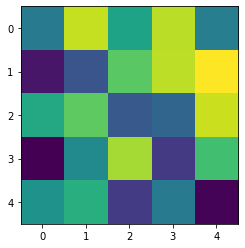

In [ ]:
import matplotlib.pyplot as plt
#filter can range from 0..4
filter=4
plt.imshow([p for p in network.conv1.parameters()][0][filter].detach().numpy().squeeze())